In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

%matplotlib notebook

In [156]:
import seaborn as sn

def plot_correlation(df):

    fig, ax = plt.subplots(1, 1, figsize=(len(df.columns), len(df.columns)), dpi=100)
    sn.heatmap(df.corr(), annot=True, ax=ax)
    ax.set_title('Correlation Matrix')
    return plt.gcf()

In [165]:
def plot_history(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.show()

    print(history.params)
    print(history.history.keys())

In [268]:
# Load Data
uav = pd.read_csv('uav_flight_data.csv')
# This should be the miminum information required, but for a single flight it does not do well
#fields = ['angular_x', 'angular_y', 'angular_z', 'linear_acceleration_x', 'linear_acceleration_y', 'linear_acceleration_z', 'position_z']
# Adding in the wind speed and battery information, the model performs much, much better.
#fields = ['angular_x', 'angular_y', 'angular_z', 'linear_acceleration_x', 'linear_acceleration_y', 'linear_acceleration_z', 'wind_speed', 'wind_angle', 'battery_voltage', 'battery_current', 'position_z']
# Now with everyone!  This produced a great plot!!!  There must be non-correlated (?) information between the accel and vel terms.
fields = ['velocity_x', 'velocity_y', 'velocity_z', 'angular_x', 'angular_y', 'angular_z', 'linear_acceleration_x', 'linear_acceleration_y', 'linear_acceleration_z', 'wind_speed', 'wind_angle', 'battery_voltage', 'battery_current', 'position_z']

# TODO: Read the datetime from the parameters file
start = dt.datetime(year=2015,month=1,day=1)
uav['time'] = uav['time'] + start.timestamp()
uav["time"] = pd.to_datetime(uav["time"], unit='s')

uav = uav[['time', *fields]]

# Do I still need this for this clean dataset?
uav.fillna(uav.bfill())

# Extract the training and test datasets
train = uav[:int(len(uav)*0.8)]
test = uav[int(len(uav)*0.8):]

In [269]:
# Prepare Data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = np.array(scaler.fit_transform(train[fields]))
print('Scaled Data Shape: ', scaled_data.shape)

#plt.plot(scaled_data)
#plt.show()

window_sample_size = int(len(scaled_data) / 10)
print('Window sample size: ', window_sample_size)

# NOTE: We are only going to use ACCEL_Z predict POS_Z to keep the problem univariate
x_train = []
y_train = []
# Build the sliding window of samples (find the technical word for this ... maybe in sktime?)
for x in range(window_sample_size, len(scaled_data)):
    x_train.append(scaled_data[x-window_sample_size:x, :-1])
    y_train.append(scaled_data[x, -1])

x_train, y_train = np.array(x_train), np.array(y_train)
print('X Train Data Shape: ', x_train.shape)
print('Y Train Data Shape: ', y_train.shape)


Scaled Data Shape:  (1447, 14)
Window sample size:  144
X Train Data Shape:  (1303, 144, 13)
Y Train Data Shape:  (1303,)


Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_97 (LSTM)              (None, 144, 128)          72704     
                                                                 
 dropout_93 (Dropout)        (None, 144, 128)          0         
                                                                 
 lstm_98 (LSTM)              (None, 144, 128)          131584    
                                                                 
 dropout_94 (Dropout)        (None, 144, 128)          0         
                                                                 
 lstm_99 (LSTM)              (None, 128)               131584    
                                                                 
 dropout_95 (Dropout)        (None, 128)               0         
                                                                 
 dense_32 (Dense)            (None, 1)               

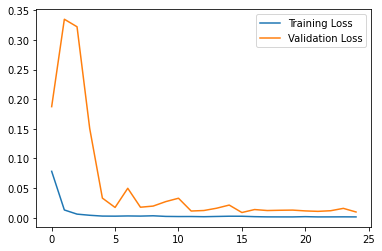

{'verbose': 1, 'epochs': 25, 'steps': 37}
dict_keys(['loss', 'val_loss'])


In [270]:
# Build The Model
model = Sequential()

model.add(LSTM(units=128, activation='tanh', return_sequences=True, input_shape=(x_train.shape[1:])))
model.add(Dropout(0.4))
model.add(LSTM(units=128, activation='tanh', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=128, activation='tanh', return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(units=1)) # Prediction of the next value

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

## Need to figure out how the data size and the batch_size work ... need to optimize for a GPU system.  Higher batch size works much better on the GPU (less overhead)
history = model.fit(x_train, y_train, epochs=25, batch_size=32, validation_split=0.1)
plot_history(history)

In [271]:
### Test the Model Accuracy on Existing Data ###
################################################

# Build the test data
x_test = []
#len(total_temp)-len(test)-prediction_days
for x in range(window_sample_size, len(scaled_data)-window_sample_size):
    x_test.append(scaled_data[x-window_sample_size:x, :-1])
x_test = np.array(x_test)
print('X Test Data Shape: ', x_test.shape)

# Make Predictions on Test Data
pred = model.predict(x_test)
print('Predictions:\n', pred[:][:10])

#np.append(x_test, pred)
#print('X Test Data Shape: ', x_test.shape)
#pred = scaler.inverse_transform(x_test)
#print('Inverse Transformed Predictions\n', pred[:][:10])

#from sklearn.metrics import mean_absolute_error
#mean_absolute_error(test['Avg_Temp'], pred)

X Test Data Shape:  (1159, 144, 13)
Predictions:
 [[-0.01141019]
 [-0.01063496]
 [-0.00998409]
 [-0.0094734 ]
 [-0.00911058]
 [-0.00890209]
 [-0.0088748 ]
 [-0.0090335 ]
 [-0.00936811]
 [-0.00987593]]


C:\Users\elisertech\.venv\testing\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\elisertech\.venv\testing\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


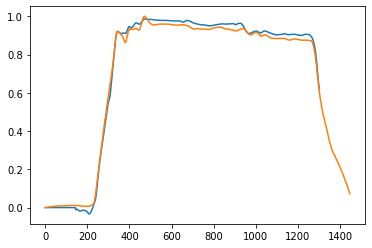

In [272]:
### Visualization ###
#####################
'''
pred_ = pd.DataFrame(test['time'])
pred_['position_x'] = pred
pred_["time"] = pd.to_datetime(pred_["time"])
print(pred_)
original = florida.loc[florida['Date'] >= '1990-01-01']
'''

import seaborn as sns
sns.lineplot(list(range(0, len(pred)+window_sample_size)), np.append(np.zeros(window_sample_size), pred[:, 0]))
sns.lineplot(list(range(0, len(scaled_data))), scaled_data[:, -1])
plt.show()